In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
import datetime
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold

In [6]:
from sklearn.model_selection import train_test_split

In [1]:
from sklift.datasets import fetch_hillstrom
from sklearn.preprocessing import OneHotEncoder
def mine_coding(dataset):
    return int(str(int(dataset['segment']))+str(int(dataset['visit'])), 2)

def mine_preproccessing():  
    bunch = fetch_hillstrom(target_col='visit')

    dataset, target, treatment = bunch['data'], bunch['target'], bunch['treatment']

    # Selecting two segments
    dataset = dataset[treatment!='Mens E-Mail']
    target = target[treatment!='Mens E-Mail']
    treatment = treatment[treatment!='Mens E-Mail'].map({
        'Womens E-Mail': 1,
        'No E-Mail': 0
    })
    cat_cols = dataset.select_dtypes(include='object').columns.tolist()
    ohe = OneHotEncoder(sparse=False)
    encoded_features = pd.DataFrame(ohe.fit_transform(dataset[cat_cols]))

    dataset = pd.concat([dataset,target,treatment],axis=1)
    dataset = dataset.drop(cat_cols,axis=1)
    dataset = pd.concat([dataset,encoded_features],axis=1)
    dataset = dataset.dropna()

    dataset['coding'] = dataset.apply(mine_coding, axis=1) 

    c = dataset['coding']
    y = dataset['visit'].astype(int)
    w = dataset['segment'].astype(int)
    X = dataset.drop(['visit','segment','coding'],axis=1)

    return X,y,w,c

In [4]:
X_mine,y_mine,w_mine,c_mine = mine_preproccessing()
X_mine[['mens',  'womens',  'newbie',         0,
               1,         2,         3,         4,         5,         6,
               7,         8,         9,        10,        11,        12]] = X_mine[['mens',  'womens',  'newbie',         0,
               1,         2,         3,         4,         5,         6,
               7,         8,         9,        10,        11,        12]].astype(int)

In [7]:
indices_learn, indices_valid = train_test_split(X_mine.index, test_size=0.3)
X_train, w_train, y_train, c_train = X_mine.loc[indices_learn], w_mine.loc[indices_learn], y_mine.loc[indices_learn], c_mine.loc[indices_learn]
X_valid, w_valid, y_valid, c_valid = X_mine.loc[indices_valid], w_mine.loc[indices_valid], y_mine.loc[indices_valid], c_mine.loc[indices_valid]

In [17]:
from tree_uplift import UpliftTree, Boosting, RandomForestUplift

In [14]:
random_state=6
rng = np.random.RandomState(random_state)
ada_boost = Boosting(n_estimators=50,
         base_classifier=UpliftTree(max_depth=5, scoring='ED', min_samples_leaf=100, 
                                    min_samples_treatment=10, n_rand_features=20, norm=False, rng=rng),
         random_state=0)
ada_boost.fit(X_train.to_numpy().astype(int), y_train, w_train)
class_ = ada_boost.predict(X_valid.to_numpy().astype(int))

In [15]:
# Uplift at k best
uplift_k = uplift_at_k(y_true=y_valid, uplift=class_, treatment=w_valid, strategy='overall', k=0.3)
# Area Under Qini Curve
tm_qini_auc = qini_auc_score(y_true=y_valid, uplift=class_, treatment=w_valid)

# Area Under Uplift Curve
tm_uplift_auc = uplift_auc_score(y_true=y_valid, uplift=class_, treatment=w_valid)

# Weighted average uplift
tm_wau = weighted_average_uplift(y_true=y_valid, uplift=class_,  treatment=w_valid)

print("Boosting: ", tm_qini_auc, tm_uplift_auc, tm_wau, uplift_k)

Boosting:  0.02209680135675642 0.010124130040022501 0.05764481197386557 0.07409217096211158


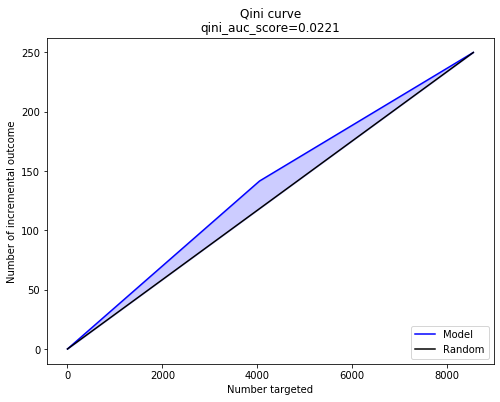

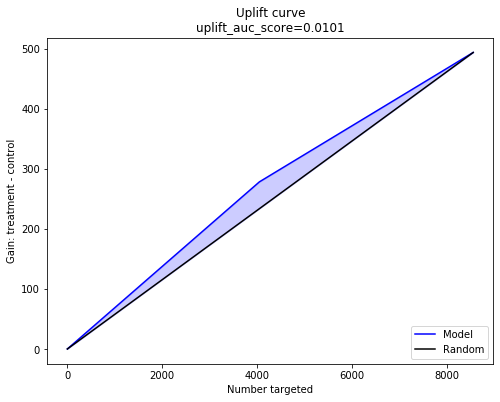

In [16]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
%matplotlib inline
plot_qini_curve(y_true=y_valid, uplift=np.array(class_).astype(int), treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=np.array(class_).astype(int), treatment=w_valid, perfect=False)

In [67]:
rf = RandomForestUplift(n_estimators=50, max_depth=6, scoring='Chi', min_samples_leaf=100, 
                   min_samples_treatment=10, n_rand_features=20, norm=False, random_state=1)

In [68]:
rf.fit(X_train, y_train, w_train)
class_, _ = rf.predict(X_valid)

In [71]:
# class_1 = class_.copy()
class_[class_1 == 1] = 0
class_[class_1 == 0] = 1

In [72]:
# Uplift at k best
uplift_k = uplift_at_k(y_true=y_valid, uplift=class_, treatment=w_valid, strategy='overall', k=0.3)
# Area Under Qini Curve
tm_qini_auc = qini_auc_score(y_true=y_valid, uplift=class_, treatment=w_valid)

# Area Under Uplift Curve
tm_uplift_auc = uplift_auc_score(y_true=y_valid, uplift=class_, treatment=w_valid)

# Weighted average uplift
tm_wau = weighted_average_uplift(y_true=y_valid, uplift=class_,  treatment=w_valid)

print("Boosting: ", tm_qini_auc, tm_uplift_auc, tm_wau, uplift_k)

Boosting:  0.009181612440355704 0.004252039322321311 0.05792652167734808 0.06323540132682073


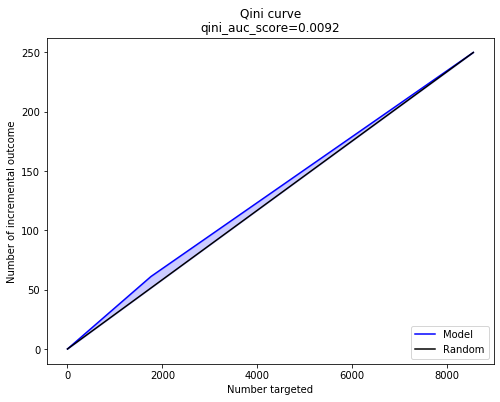

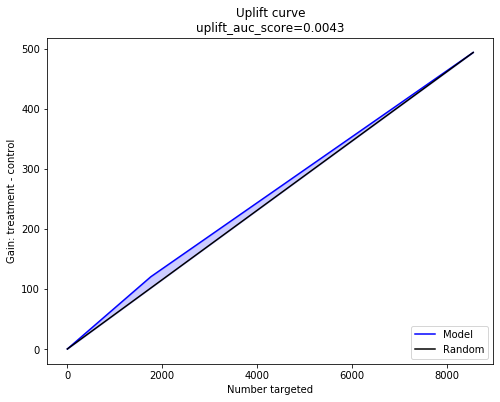

In [73]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
%matplotlib inline
plot_qini_curve(y_true=y_valid, uplift=np.array(class_).astype(int), treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=np.array(class_).astype(int), treatment=w_valid, perfect=False)